In [45]:
from __future__ import division, print_function, absolute_import

import GPy
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import patches
%matplotlib inline

from safe_learning import *

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

from Functions import *
import gymnasium as gym
from gym.envs.classic_control import PendulumEnv
from stable_baselines3 import DDPG


## Heads-up

The following code models an inverted pendulum, and uses a GP model to determine the safe region of attraction (ROA). The following is inteded to illustrate the algorithm, not to be high-performance code. As such, the code will run very slowly, with the main bottleneck being the repeated GP predictions of the dynamics. There are several obvious points that could make the code run faster
* A less conservative Lipschitz constant will allow coarser discretizations and therefore faster computations.
* Only evaluating states close to the boundary of the safe set, since those are the only states that are able to expand the ROA over time.
* Only partially update the GP predictions of the model where needed, rather than everywhere (lots of predictions are at states that are either unsafe and too far away from the current level set, or are already safe and evaluations there have no hope of expanding the ROA

## Neural networks


In [46]:
class Lyapunov_Net(torch.nn.Module):
    
    def __init__(self,n_input,n_hidden,n_output):
        super(Lyapunov_Net, self).__init__()
        torch.manual_seed(2)
        self.layer1 = nn.Linear(n_input, n_hidden)
        self.layer2 = nn.Linear(n_hidden,n_output)
        # self.control = torch.nn.Linear(n_input,1,bias=False)
        # self.control.weight = torch.nn.Parameter(lqr)

    def forward(self,x):
        sigmoid = nn.Tanh()
        h_1 = sigmoid(self.layer1(x))
        out = sigmoid(self.layer2(h_1))
        # u = self.control(x)
        return out

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=3, output_size=1):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Input size: 3 (3D float input), Output size: 64
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 32)
        self.fc6 = nn.Linear(32, output_size)  # Output size: 1 (1D float output)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x
    

# Define the neural network model
class dynamic_NN(nn.Module):
    def __init__(self, input_size=3, output_size=1):
        super(dynamic_NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Input size: 3 (3D float input), Output size: 64
        self.fc2 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, output_size)  # Output size: 1 (1D float output)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc6(x)
        return x
    

## Parameters

In [47]:
# Lyapunov 
D_in = 2            # input dimension
H1 = 6              # hidden dimension
D_out = 1           # output dimension
dt = 0.05
torch.manual_seed(10)
epsilon = 0

## Load models from file

Lyapunov, Policy, Dynamics


In [57]:
# Load the saved model
Lyapunov_model = Lyapunov_Net(D_in,H1, D_out)
Lyapunov_model.load_state_dict(torch.load('LNN_tune_1x0.pth'))
policy_model = DDPG.load("ddpg_pendulum_10k")
dynamic_model = dynamic_NN(3, 2)
dynamic_model.load_state_dict(torch.load('model_2_NN2.pth'))
print("L:",Lyapunov_model)
print("P:",policy_model)
print("D:",dynamic_model)
print("Model loaded successfully!")

L: Lyapunov_Net(
  (layer1): Linear(in_features=2, out_features=6, bias=True)
  (layer2): Linear(in_features=6, out_features=1, bias=True)
)
P: <stable_baselines3.ddpg.ddpg.DDPG object at 0x0000017CAC7F1F88>
D: dynamic_NN(
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=2, bias=True)
)
Model loaded successfully!


## Discretization

We discretize the state into a grid world. Since we will use the conservative, theoretical Lipschitz constant of $\dot{V}(x)$ from Lemma 5, we have to discretize very finely. In practice, one may be tempted to pick larger values.

In [50]:
# Discretization constant
tau = 0.02

# x_min, x_max, accuracy
grid_param = [(-0.5, 0.5, tau),
              (-0.5, 0.5, tau)]

# Used to plot the safe set later
extent = np.array([grid_param[0][0], grid_param[0][1],
                   grid_param[1][0], grid_param[1][1]])

# Define a grid with combinations of states
grid = [np.arange(*x) for x in grid_param]
num_samples = [len(x) for x in grid]
grid = combinations(grid)
grid[:,0] = grid[:,0] * np.pi *2
grid[:,1] = grid[:,1] * 4
grid_3 = np.hstack((np.cos(grid[:,0]).reshape(-1,1), np.sin(grid[:,1]).reshape(-1,1), grid[:,1].reshape(-1,1)))
# Initial safe set
# grid_true = denormalize_x(grid)
S0 = np.logical_and(np.abs(grid[:, 0]) < np.deg2rad(5),
                    np.abs(grid[:, 1]) < np.deg2rad(10))

if not np.any(S0):
    print('No initial safe points!')
print('Grid size: {0} combinations in {1}x{2} discretized with tau={3}'
      .format(len(grid), extent[:2], extent[2:], tau))

Grid size: 2500 combinations in [-0.5  0.5]x[-0.5  0.5] discretized with tau=0.02


## Dynamics

In [51]:

def dynamics(x):
    """Return the linearized, closed-loop, prior, normalized dynamics.
    
    Parameters
    ----------
    x: np.array
        2D array with one normalized state on each column
        
    Returns
    -------
    x_dot: np.array
        2D array with normalized derivative states on each column
    """
    dt = 0.05
    # x = np.asarray(x)
    # u = np.empty(len(x))
    # for i in range(len(x)):
    #     state = torch.tensor([np.cos(x[i][0]), np.sin(x[i][0]), x[i][1]], dtype=torch.float32)
    #     u[i] = policy_model(state).detach().numpy()
    # u = u.reshape(-1,1)/1.75
    global policy_model, dynamic_model
    x_3 = np.vstack((np.cos(x[:,0]), np.sin(x[:,1]), x[:,1])).T
    u, _ = policy_model.predict(x_3)
    x_u = torch.from_numpy(np.concatenate((x,u),axis=1)).to(dtype=torch.float32)

    # x = torch.tensor(x,dtype=torch.float32)
    # u = torch.tensor(u,dtype=torch.float32)
    # x_u = torch.cat((torch.from_numpy(x).to(dtype=torch.float32),torch.from_numpy(u).to(dtype=torch.float32)), dim=1)
    next_state = dynamic_model.forward(x_u)
    accelerate = (next_state[:,1].detach().numpy() - x[:,1]) / dt
    f = np.vstack((x[:,1], accelerate))
    return f.T
    
f = dynamics(grid)

## Calculate Lyapunov cost and derivate

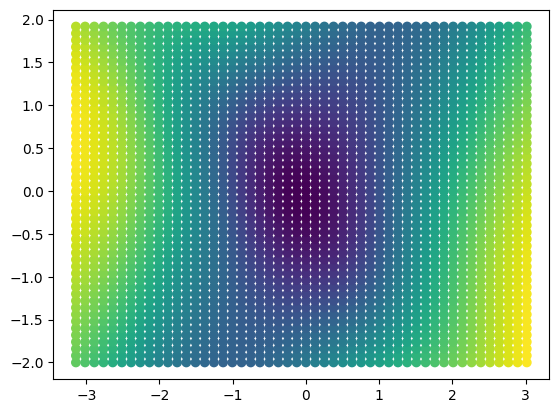

In [58]:
# V(x) = x.T P x
# dV(x)/dx = 2 x.T P

grid_tensor = torch.from_numpy(grid).to(torch.float32)
V = Lyapunov_model(grid_tensor)

def dtanh(s):
    # Derivative of activation
    return 1.0 - s**2
# Compute lie derivative of V : L_V = ∑∂V/∂xᵢ*fᵢ
dV = torch.mm(torch.mm(dtanh(V),Lyapunov_model.layer2.weight) * dtanh(torch.tanh(torch.mm(grid_tensor,Lyapunov_model.layer1.weight.t())+Lyapunov_model.layer1.bias)),Lyapunov_model.layer1.weight)
L_V = torch.diagonal(torch.mm(dV, torch.from_numpy(f.T).to(torch.float32)),0).detach().numpy()
V = V.detach().numpy().reshape(-1)
dV = dV.detach().numpy()

plt.scatter(grid[:, 0], grid[:, 1], c=V, cmap='viridis')

## Gaussian process model of the error

We define the state vector $\mathbf{x} = [\mathbf{x}_1, \mathbf{x}_2] = [\theta, \dot{\theta}]$, so that the dynamics can be written as
$$
\dot{\mathbf{x}} =
\left[
\begin{matrix}
\mathbf{x}_2 \\
\frac{mgl \sin(\mathbf{x}_1) + \tau}{m l^2}
\end{matrix} \right]
$$

The first part of this equation says that the angle is equal to the integrated angular velocity. This is a intuitively true, irrespective of model errors. As such, we only learn the model error of the second part of the dynamics. That is
$$\dot{\mathbf{x}} =
\left[
\begin{matrix}
\mathbf{x}_2 \\
\frac{mgl \sin(\mathbf{x}_1) + \tau}{m l^2} + g_\pi(\mathbf{x})
\end{matrix} \right]
$$

As a kernel we choose $k(x,x') = k_{\mathrm{linear}}(x, x') * k_{\mathrm{Matern}}(x, x')$, the product of a linear and a Matern kernel. This encodes nonlinear functions with linearly increasing amplitude. For more details what this kernel encodes, see the one-dimensional example.

In [59]:
# Mean function for the GP with the prior dynamics
mf = GPy.core.Mapping(2, 1)
mf.f = lambda x: dynamics(x)[:, [1]]
mf.update_gradients = lambda a,b: None

# Matern kernel multiplied with linear kernel
kernel = (GPy.kern.Matern32(input_dim=2, lengthscale=.2, variance=5, name='radial') *
          GPy.kern.Linear(input_dim=2, name='linear', variances=1))

# Measurement model
likelihood = GPy.likelihoods.Gaussian(variance=0.05**2)

# GP with initial measurement at (0, 0), 0
gp = GPy.core.GP(np.array([[0, 0]]), np.array([[0]]),
                 kernel, likelihood, mean_function=mf)


def predict_model(gp, x):
    """Predict the model using the gp dynamics
    
    Given that the model error only affects the second derivative,
    the first state has zero variance and is equal to the prior model.
    
    Parameters
    ----------
    gp: GPy.core.GP
        The GP model of the dynamics (including prior)
    x: np.array
        2D array. Each column has one state at which
        to predict the dynamics
        
    Returns
    -------
    mean: np.array
        The mean dynamics at x
    var: np.array
        Variance of the dynamics at x
    """
    gp_mean, gp_var = gp._raw_predict(x)
    # Augment with deterministic model for first state
    gp_mean = np.hstack([prior_dynamics(x)[:, [0]], gp_mean])
    gp_var = np.hstack([np.zeros_like(gp_var), gp_var])
    return gp_mean, gp_var

## Lipschitz constant

The Lipschitz constant is defined via the high-probability Lipschitz constant of the GP model, as well as the linear dynamics. Importantly, here we use the local Lipschitz constants. Since the kernel we have choosen implies increasing Lipschitz constants with distance from the origin. the worst-case Lipschitz constant would be too conservative.

In [40]:
# # Lyapunov function:
# V, dV = quadratic_lyapunov_function(grid, Pn)
# V_max = np.max(V)
# accuracy = V_max / 1e10

# # Lipschitz constants of Lyapunov function
# B_dV = L_V = np.max(np.abs(dV), axis=1)
# L_dV = np.max(Pn)

# # Kernel parameters
# kernel_lengthscale = np.min(gp.kern.radial.lengthscale).squeeze()
# kernel_var = gp.kern.radial.variance.values.squeeze()
# linear_var = gp.kern.linear.Kdiag(grid).squeeze()

# # Dynamics Lipschitz constants
# L_g = 2 * np.sqrt(kernel_var * linear_var) / kernel_lengthscale
# L_f = np.max(np.abs(An - Bn.dot(Kn)))

# # Function bounds
# B_g = 2 * np.sqrt(kernel_var * linear_var)
# B_f = prior_dynamics(grid)[:, 1]

# L = (B_g + B_f) * L_dV + B_dV * (L_g + L_f)

## True safe levelset

To get an intuition about the task at hand, we compute the maximum, safe level set (ROA) according to the true and prior dynamics. The learning algorithm only has access to the prior dynamics model, not the true model!

The plot shows the maximum level set (orange), and the region where $\dot{V}$ is sufficiently small (red). It can be seen that the prior model estimates a safe region that is too large, since it considers a lighter mass. Also, the third plot shows that we cannot recover the maximum level set with the learning method, since it considers $\dot{V}(x) < -L\tau$, rather than $\dot{V}(x) < 0$. For finer discretizations the two sets will get closer and closer to each other.

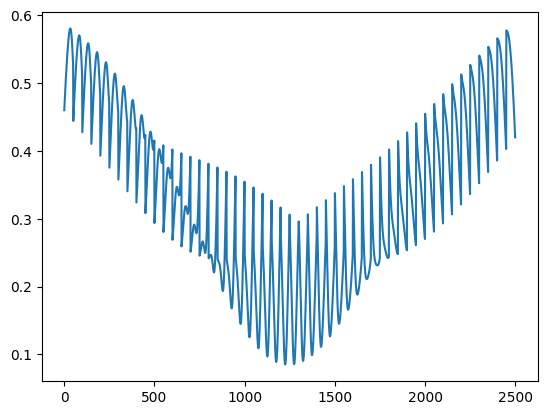

In [61]:
plt.plot(V)


[ True  True  True ...  True  True  True] [0.45986196 0.4654868  0.47104234 ... 0.43212315 0.4260434  0.41990516] 5.803364515304565e-11
none,  <class 'numpy.float64'>
find 5.803364515304565e-11
line, bound, accuracy [0, 0.5803364515884902] 5.803364515304565e-11 True False
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
[0.08523224666390122, 0.08523224669768124]
line, bound, accuracy [0.08523224666390122, 0.08523224669768124] 5.803364515304565e-11 True False
[ True  True  True ...  True  True  True]
[False False False ... False False False] 0.08523224666390122


ValueError: maximum supported dimension for an ndarray is 32, found 2500

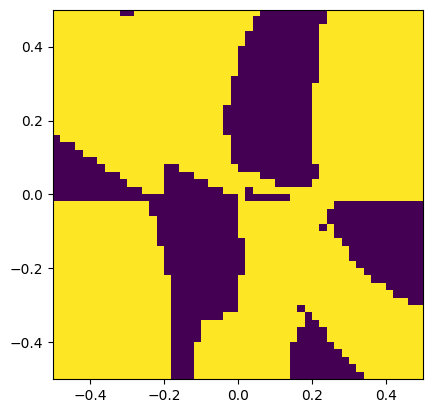

In [64]:

from safe_learning import *

V_max = np.max(V)
accuracy = V_max / 1e10
V_dot_true = compute_v_dot_upper_bound(dV, dynamics(grid), None)

S = get_safe_set(V_dot_true, 0, S0=None)
plt.imshow(np.reshape(S, num_samples).T, extent=extent, origin='lower')
print(S, V, accuracy)
c = find_max_levelset(S_true, V, accuracy)
print(S)
S[:] = V <= c
print(S, c)
num_samples = [len(x) for x in grid]
plt.imshow(np.reshape(V <= c, num_samples).T, extent=extent, origin='lower', alpha=0.3, cmap='viridis')
plt.set_title('True safe set (V_dot < 0)')
plt.show()

In [11]:
V_dot_true = compute_v_dot_upper_bound(dV, dynamics(grid), None)

# fig, axes = plt.subplots(1, 2, figsize=(10, 20))

S_true = get_safe_set(V_dot_true, 0, S0=None)
axes[0].imshow(np.reshape(S_true, num_samples).T, extent=extent, origin='lower')
c_true = find_max_levelset(S_true, V, accuracy)
axes[0].imshow(np.reshape(V <= c_true, num_samples).T, extent=extent, origin='lower', alpha=0.3, cmap='viridis')
axes[0].set_title('True safe set (V_dot < 0)')

# S_true_L = get_safe_set(V_dot_true, -L*tau, S0=S0)
# c_true_L = find_max_levelset(S_true_L, V, accuracy)
# axes[2].imshow(np.reshape(S_true_L, num_samples).T, extent=extent, origin='lower')
# axes[2].set_title('True safe set (V_dot < -L*tau)')
# axes[2].imshow(np.reshape(V < c_true_L, num_samples).T, extent=extent, origin='lower', alpha=0.3, cmap='viridis')
# plt.show()

# print('Number of true safe points:   {0}/{3}\n'
#       'Number of prior safe points:  {1}/{3}\n'
#       'Number of finite safe points: {2}/{3}\n'.format(np.count_nonzero(V < c_true),
#                                                        np.count_nonzero(V < c_prior),
#                                                        np.count_nonzero(V < c_true_L),
#                                                        grid.shape[0]))

NameError: name 'axes' is not defined

## Online learning

Now let us see how the learning algorithm performs. We compute the maximum level set based on the GP estimate of the dynamics, and sample the most uncertain state within for 100 iterations.

In [109]:
import gymnasium as gym
from gym.envs.classic_control import PendulumEnv
# Try to import a nice progress bar
try:
    from tqdm import tqdm
except:
    tqdm = lambda x: x

'''

# Problem 1. how to train the model to generate Lyapunov function? 
    In LQR, K is used to generate policy, P can generate Lyapunov function. K = R^-1 * B^T * P
    P = sp.linalg.solve_continuous_are(A, B, Q, R)
    K = np.linalg.solve(R, B.T.dot(P))   

# Problem 2. in the regression model with continuous action space, the output has no probability or confidence like a classification model with discrete action space.
# Problem 3. Normalization and policy running time in prior_dynamics(). Still need time to solve gradually.

'''

    
def NN_dynamics(given_state, size=3):
    
    global policy_model
    global dynamic_model
    if size==2:
        state = torch.tensor([np.cos(given_state[0]), np.sin(given_state[0]), given_state[1]], dtype=torch.float32)
    else:
        state = torch.tensor(given_state, dtype=torch.float32)
    action = policy_model(state)
    NextS_pred = dynamic_model(torch.cat((state, action)))
    return action.detach().numpy(), NextS_pred.detach().numpy()
    
def update_gp():
    # env = gym.make("Pendulum-v1")
    env = PendulumEnv()
    dynamics_mean, dynamics_var = predict_model(gp, grid)
    V_dot = compute_v_dot_upper_bound(dV, dynamics_mean, dynamics_var, beta=2.)
    S = get_safe_set(V_dot, -L*tau, S0=S0)
    c = find_max_levelset(S, V, accuracy)
    S[:] = V <= c
    max_id = np.argmax(dynamics_var[S, 1])
    max_state = grid[S][[max_id], :].copy()
    env.state = np.array(max_state[0])

    # max_state [theta, velocity]
    # obs [cos, sin, velocity]
    action, NextS_pred = NN_dynamics(max_state[0], 2)
    next_obs, reward, done, info, _ = env.step(action)
    print("Current state:", max_state, "\n Next_state_gym", next_obs, "\n Next_state_pred", NextS_pred, "\n Next_state_ode", denormalize_x(true_dynamics(max_state)[0]) )
    print("Action_LQR", control_law(max_state), "Action_NN", action)

    gp.set_XY(np.vstack([gp.X, max_state]),
              np.vstack([gp.Y, true_dynamics(max_state)[:, [1]]]))
    env.close()
    return S

# Update the GP model 100 times
for i in tqdm(range(10)):
    S = update_gp()
    
print('Number of estimated safe points: {0}% relative to true dynamics with V_dot < 0'
      .format(np.count_nonzero(S) / np.count_nonzero(V < c_true)))


  0%|          | 0/10 [00:00<?, ?it/s]

control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]


 10%|█         | 1/10 [01:15<11:19, 75.48s/it]

control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]
Current state: [[-0.03   0.038]] 
 Next_state_gym [ 0.9995799  -0.02898223  0.02027432] 
 Next_state_pred [ 1.0215366  -0.05860131  0.02044548] 
 Next_state_ode [ 0.16831898 -1.41753177]
Action_LQR [[-0.09020682]] Action_NN [0.03180627]
control_law [[-0.        ]
 [-0.09020682]] 
model [[-0.5834285 ]
 [ 0.03180627]]
control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]


 20%|██        | 2/10 [02:29<09:55, 74.44s/it]

control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]
Current state: [[ 0.03  -0.038]] 
 Next_state_gym [ 0.9997818   0.02088873 -0.18219502] 
 Next_state_pred [ 0.93904114  0.07407808 -0.18222992] 
 Next_state_ode [-0.16831898  1.41753177]
Action_LQR [[0.09020682]] Action_NN [-1.1112777]
control_law [[-0.        ]
 [-0.09020682]
 [ 0.09020682]] 
model [[-0.5834285 ]
 [ 0.03180627]
 [-1.1112777 ]]
control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]


 30%|███       | 3/10 [03:42<08:38, 74.06s/it]

control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]
Current state: [[0.016 0.016]] 
 Next_state_gym [ 0.99996245  0.00866809 -0.14663601] 
 Next_state_pred [ 0.93068665  0.06794503 -0.13703416] 
 Next_state_ode [ 0.07087115 -1.4084134 ]
Action_LQR [[-0.15069161]] Action_NN [-1.1642367]
control_law [[-0.        ]
 [-0.09020682]
 [ 0.09020682]
 [-0.15069161]] 
model [[-0.5834285 ]
 [ 0.03180627]
 [-1.1112777 ]
 [-1.16423666]]
control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]


 40%|████      | 4/10 [04:57<07:25, 74.31s/it]

control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]
Current state: [[ 0.032 -0.036]] 
 Next_state_gym [ 0.9997451   0.02257818 -0.18839806] 
 Next_state_pred [ 0.92768127  0.08139953 -0.18412511] 
 Next_state_ode [-0.15946009  1.24147763]
Action_LQR [[0.07137037]] Action_NN [-1.1759598]
control_law [[-0.        ]
 [-0.09020682]
 [ 0.09020682]
 [-0.15069161]
 [ 0.07137037]] 
model [[-0.5834285 ]
 [ 0.03180627]
 [-1.1112777 ]
 [-1.16423666]
 [-1.17595983]]
control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]


 50%|█████     | 5/10 [06:18<06:23, 76.64s/it]

control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]
Current state: [[-0.032  0.036]] 
 Next_state_gym [ 0.99954456 -0.03017714  0.03636552] 
 Next_state_pred [ 1.0209906  -0.06381553  0.02821107] 
 Next_state_ode [ 0.15946009 -1.24147763]
Action_LQR [[-0.07137037]] Action_NN [0.16240951]
control_law [[-0.        ]
 [-0.09020682]
 [ 0.09020682]
 [-0.15069161]
 [ 0.07137037]
 [-0.07137037]] 
model [[-0.5834285 ]
 [ 0.03180627]
 [-1.1112777 ]
 [-1.16423666]
 [-1.17595983]
 [ 0.16240951]]
control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]


 60%|██████    | 6/10 [07:43<05:17, 79.42s/it]

control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]
Current state: [[-0.016 -0.016]] 
 Next_state_gym [ 0.9998807  -0.01544748  0.0110381 ] 
 Next_state_pred [ 1.0224465  -0.05874209 -0.0028476 ] 
 Next_state_ode [-0.07087115  1.4084134 ]
Action_LQR [[0.15069161]] Action_NN [0.26025057]
control_law [[-0.        ]
 [-0.09020682]
 [ 0.09020682]
 [-0.15069161]
 [ 0.07137037]
 [-0.07137037]
 [ 0.15069161]] 
model [[-0.5834285 ]
 [ 0.03180627]
 [-1.1112777 ]
 [-1.16423666]
 [-1.17595983]
 [ 0.16240951]
 [ 0.26025057]]
control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]


 70%|███████   | 7/10 [09:02<03:57, 79.32s/it]

control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]
Current state: [[ 0.034 -0.016]] 
 Next_state_gym [ 0.9997022   0.02440187 -0.19191408] 
 Next_state_pred [ 0.89535093  0.10028164 -0.18862559] 
 Next_state_ode [-0.07087115 -0.00883698]
Action_LQR [[-0.04613615]] Action_NN [-1.3427278]
control_law [[-0.        ]
 [-0.09020682]
 [ 0.09020682]
 [-0.15069161]
 [ 0.07137037]
 [-0.07137037]
 [ 0.15069161]
 [-0.04613615]] 
model [[-0.5834285 ]
 [ 0.03180627]
 [-1.1112777 ]
 [-1.16423666]
 [-1.17595983]
 [ 0.16240951]
 [ 0.26025057]
 [-1.34272778]]
control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]


 80%|████████  | 8/10 [10:14<02:34, 77.19s/it]

control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]
Current state: [[-0.014  0.038]] 
 Next_state_gym [ 0.99985933 -0.01677415 -0.05549869] 
 Next_state_pred [ 0.99639404 -0.00810878 -0.04485585] 
 Next_state_ode [ 0.16831898 -1.87105676]
Action_LQR [[-0.15319171]] Action_NN [-0.5533269]
control_law [[-0.        ]
 [-0.09020682]
 [ 0.09020682]
 [-0.15069161]
 [ 0.07137037]
 [-0.07137037]
 [ 0.15069161]
 [-0.04613615]
 [-0.15319171]] 
model [[-0.5834285 ]
 [ 0.03180627]
 [-1.1112777 ]
 [-1.16423666]
 [-1.17595983]
 [ 0.16240951]
 [ 0.26025057]
 [-1.34272778]
 [-0.5533269 ]]
control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]


 90%|█████████ | 9/10 [11:36<01:18, 78.55s/it]

control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]
Current state: [[-0.034  0.016]] 
 Next_state_gym [ 0.9995391  -0.0303581   0.07274475] 
 Next_state_pred [ 1.0088348  -0.07507856  0.0646085 ] 
 Next_state_ode [0.07087115 0.00883698]
Action_LQR [[0.04613615]] Action_NN [0.5482656]
control_law [[-0.        ]
 [-0.09020682]
 [ 0.09020682]
 [-0.15069161]
 [ 0.07137037]
 [-0.07137037]
 [ 0.15069161]
 [-0.04613615]
 [-0.15319171]
 [ 0.04613615]] 
model [[-0.5834285 ]
 [ 0.03180627]
 [-1.1112777 ]
 [-1.16423666]
 [-1.17595983]
 [ 0.16240951]
 [ 0.26025057]
 [-1.34272778]
 [-0.5533269 ]
 [ 0.54826558]]
control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]


100%|██████████| 10/10 [12:47<00:00, 76.72s/it]

control_law [[ 1.]
 [ 1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [-1.]] 
model [[ 1.72545731]
 [ 1.72687173]
 [ 1.72828639]
 ...
 [-1.77531612]
 [-1.77529848]
 [-1.77528083]]
Current state: [[ 0.014 -0.038]] 
 Next_state_gym [ 0.9999695   0.0078096  -0.12380633] 
 Next_state_pred [ 0.99078834  0.02032246 -0.13382275] 
 Next_state_ode [-0.16831898  1.87105676]
Action_LQR [[0.15319171]] Action_NN [-0.6420399]
control_law [[-0.        ]
 [-0.09020682]
 [ 0.09020682]
 [-0.15069161]
 [ 0.07137037]
 [-0.07137037]
 [ 0.15069161]
 [-0.04613615]
 [-0.15319171]
 [ 0.04613615]
 [ 0.15319171]] 
model [[-0.5834285 ]
 [ 0.03180627]
 [-1.1112777 ]
 [-1.16423666]
 [-1.17595983]
 [ 0.16240951]
 [ 0.26025057]
 [-1.34272778]
 [-0.5533269 ]
 [ 0.54826558]
 [-0.6420399 ]]
Number of estimated safe points: 0.0064544180153976475% relative to true dynamics with V_dot < 0


##### Warning: This is non-optimized, academic code. Executing the following cell may take roughly a minute on a decent laptop.

# Plot results

We plot the resulting estimate. By restricting ourselves to the levelset $\dot{V} \leq -L \tau$, we cannot reach the true safe set. However, if we pick a less conservative Lipschitz constant and discretize at a finer rate, the two will approach each other.

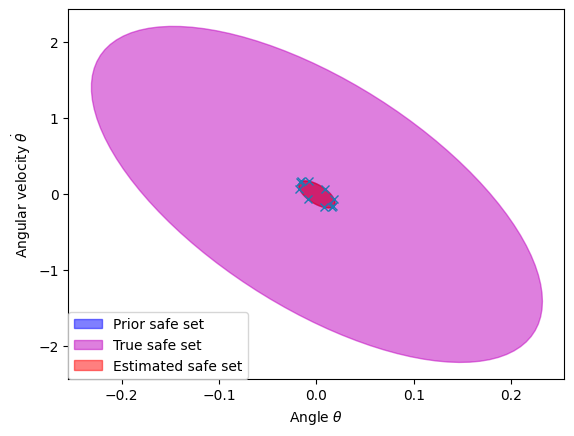

In [110]:
def denorm_ellipse(P, level):
    """Return the ellipse _bounds, but denormalized."""
    x0, x1_u, x1_l = ellipse_bounds(P, level)
    return Tx[0,0] * x0, Tx[1,1] * x1_u, Tx[1,1] * x1_l

c_est = find_max_levelset(S, V, accuracy)
colors = ['b', 'm', 'r']

plt.fill_between(*denorm_ellipse(Pn, c_prior), color=colors[0], alpha=0.5)
plt.fill_between(*denorm_ellipse(Pn, c_true), color=colors[1], alpha=0.5)
plt.fill_between(*denorm_ellipse(Pn, c_est), color=colors[2], alpha=0.5)

patch0 = patches.Patch(color=colors[0], alpha=0.5, label='Prior safe set')
patch1 = patches.Patch(color=colors[1], alpha=0.5, label='True safe set')
patch2 = patches.Patch(color=colors[2], alpha=0.5, label='Estimated safe set')

legs = [patch0, patch1, patch2]
labels = [x.get_label() for x in legs]
leg = plt.legend(legs, labels, loc=3, borderaxespad=0)

data = denormalize_x(gp.X[1:, :])
plt.plot(data[:, 0], data[:, 1], 'x')

plt.xlabel(r'Angle $\theta$')
plt.ylabel(r'Angular velocity $\dot{\theta}$')
plt.show()